# Agent-Based Traffic Model

## Background

This model is a looped implementation of the cellular automata (CA) described by Nagel and Schreckenberg (NaSch).
The NaSch CA model splits agent (vehicle) actions into four stages:
1. Acceleration
2. Braking
3. Randomisation
4. Vehicle Movement

In this implementation the 4th action is separated from the other actions to simulate simultaneous activation of the agents.
This isn't strictly necessary for non-multithreaded processes but ensures that vehicle positions wouldn't cause conflicts if it were multithreaded.

## Implementation
The model is written in Python using the Mesa ABM framework which allows for easy visualisation.
This is a demonstration of running a Mesa model in an IPython Notebook which is an alternative to running it using javascript visualisation in a webpage.

The actual model and agent code are implemented in model.py, in the same directory as this notebook.
Below, we will import the model class, instantiate it, run it, and plot the average speed of the agents.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

from model import NaSchTraffic

Now we instantiate a model instance: a 1x30 grid, with a 20% chance of an agent being placed in each cell, and a max vehicle speed of 4.

In [9]:
model = NaSchTraffic(1, 60, 5, 4, seed=1)

We want to run the model until it's settles, but it's hard to tell when that is so let's just run it for 100 steps:

In [10]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

100


The model has a DataCollector object, which checks and stores the average speed of the agents at every step.
It also collects the individual speed and position of each agent at each step.
It can also generate a pandas DataFrame of the data it has collected.

In [11]:
model_out = model.datacollector.get_model_vars_dataframe()

The dataframe for the model:

In [12]:
model_out.head()

,Average_Speed,Happy
0,0.0,0
1,0.6,0
2,1.6,5
3,2.4,4
4,2.8,5


Finally, we can plot the 'AverageSpeed' series:

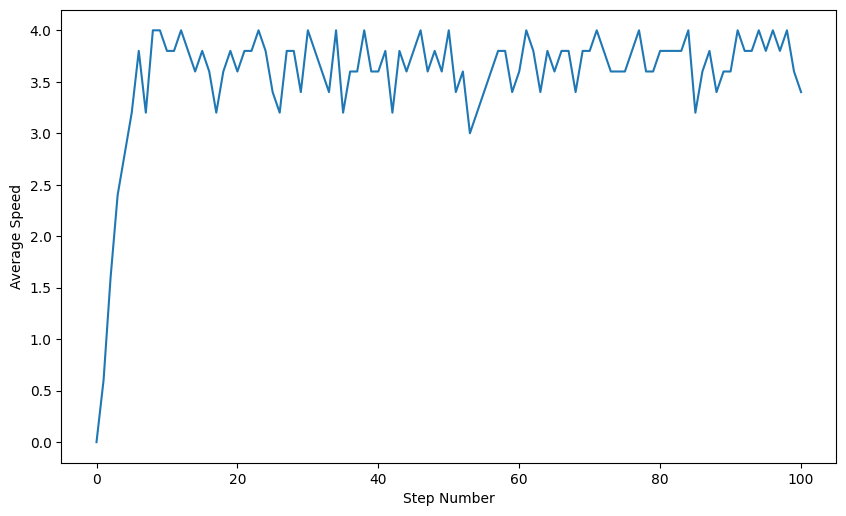

In [13]:
plt.plot(model_out.Average_Speed)
plt.xlabel('Step Number')
plt.ylabel('Average Speed')
plt.show()

For testing purposes, here is the dataframe for the agents giving each agent's x position and speed at each step.

*commented out as not yet reimplemented*

In [14]:
# agent_out = model.datacollector.get_agent_vars_dataframe()
# agent_out.head()

## Effect of speed limit and traffic vehicle_quantity on traffic average speed

Now, we can do a parameter sweep to see how speed changes against number of vehicles and the max speed.

First we make a new function to collect the average speed during the second half of the simulation.

In [15]:
from mesa.batchrunner import BatchRunner
import itertools

def get_averages(model):
    """
    Find the average speed of all the agents over the last 30 steps.
    """

    total_averages = 0
    list_length = 0
    selected_averages = itertools.islice(model.averages, 60)
    for average_speed in selected_averages:
        total_averages += average_speed
        list_length+=1

    return total_averages / list_length

model_reporters={"Average_Speed": get_averages}

Now, we set up the batch run, with a dictionary of fixed and changing parameters.
Let's vary the maximum speed, and the number of vehicles.

In [16]:
fixed_params = {"height": 1, "width": 60}
variable_parms = {"general_max_speed": range(1, 6), "vehicle_quantity": range(1, 20+1)}

Then we create a batch runner object to conduct the parameter sweep.
The number of iterations is the number of runs it does of the whole parameter space.

In [17]:
param_sweep = BatchRunner(NaSchTraffic,
                          variable_parameters=variable_parms, fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=120,
                          model_reporters=model_reporters)

Then we run the parameter sweep (this can take a few minutes).

In [18]:
param_sweep.run_all()

1000it [00:22, 44.63it/s]


Now we create the dataframe for the data collected like we did for the single model run.

In [19]:
df = param_sweep.get_model_vars_dataframe()
df.head()

,general_max_speed,vehicle_quantity,Run,Average_Speed,height,width
0,1,1,0,0.616667,1,60
1,1,1,1,0.750000,1,60
2,1,1,2,0.783333,1,60
3,1,1,3,0.666667,1,60
4,1,1,4,0.566667,1,60


A scatter plot can be used to show how the parameters affect each other.
We have varied more than one parameter, so we should try to visualise the interactions.
One way of achieving this is with coloured data points:

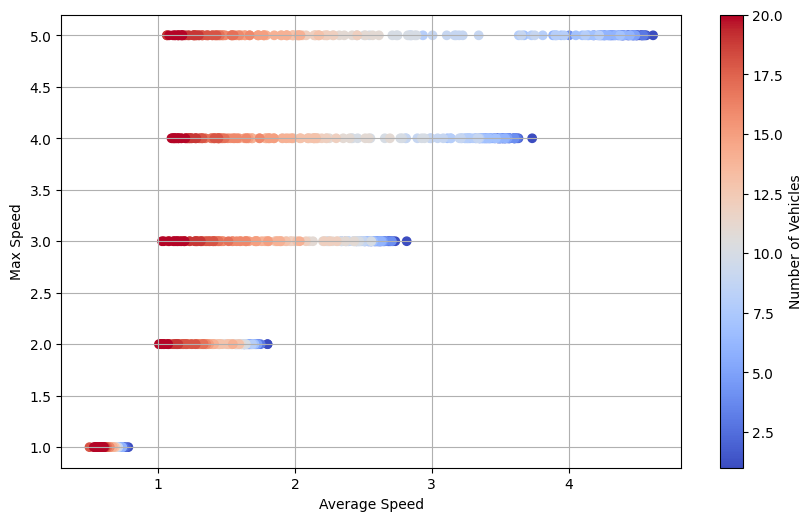

In [21]:
plt.scatter(df.Average_Speed, df.general_max_speed, c=df.vehicle_quantity, cmap=plt.cm.coolwarm)
plt.xlabel('Average Speed')
plt.ylabel('Max Speed')
bar = plt.colorbar()
bar.set_label('Number of Vehicles')
plt.grid(True)

If coloured data points aren't showing the trends clearly enough another option is a 3D scatter plot:

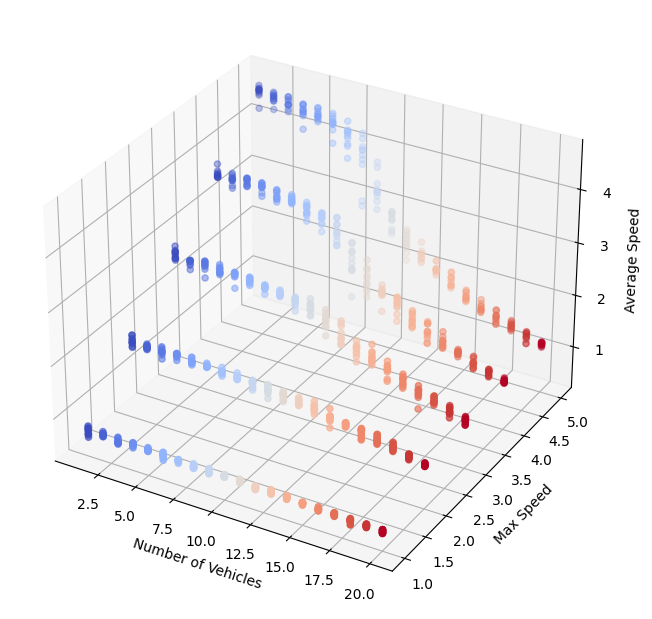

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
# fig.tight_layout(pad=4)
ax = Axes3D(fig)
ax.scatter(df.vehicle_quantity, df.general_max_speed, df.Average_Speed, c=df.vehicle_quantity, cmap=plt.cm.coolwarm)
ax.set_zlabel('Average Speed')
plt.xlabel('Number of Vehicles')
plt.ylabel('Max Speed')
plt.show()